# ABL with MMC forcing

In [1]:
# Load the modules

# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)
import MMCutil as writeMMC

# Load the libraries
import numpy as np
import pandas as pd
import amrwind_frontend as amrwind
import matplotlib.pyplot    as plt
from scipy.interpolate import CubicSpline
from scipy.signal import savgol_filter
from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator

from scipy.optimize import root_scalar
from functools import partial

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Add this to load local packages
import sys
#sys.path.insert(1, '/ascldap/users/lcheung/.local/lib/python2.7/site-packages')
import utm
import matplotlib.patches as patches

In [3]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    return np.abs(a - a0).argmin()

# Merging profiles
def tanhblend(x, x0, w):
    return 0.5*(1+np.tanh((x-x0)/w))

def tanhblendprofiles(profa, profb, x, x0, w):
    tanha = profa*(1-tanhblend(x, x0, w))
    tanhb = profb*(tanhblend(x, x0, w))
    return tanha + tanhb

def interpprofile(newz, z, prof):
    spl = CubicSpline(z, prof)
    interpprof = spl(newz)
    return interpprof
    #return np.interp(newz, z, prof)
    
def blendprofiles(newz, zA, profA, Bconst, x0, w):
    newprofA = interpprofile(newz, zA, profA)
    newprofB = Bconst*np.ones(len(newz)) #interpprofile(newz, zB, profB)
    return tanhblendprofiles(newprofA, newprofB, newz, x0, w)

In [4]:
# Set up the MMC profiles
profiledir  ='../'
ldr_heights = np.loadtxt(profiledir+'/A1scan_heights.dat')
ldr_time    = np.loadtxt(profiledir+'/A1scan_times1.dat')
ldr_WS      = np.nan_to_num(np.loadtxt(profiledir+'/A1scan_WS1.dat'), 0.0)
ldr_WD      = np.nan_to_num(np.loadtxt(profiledir+'/A1scan_WD1.dat'), 0.0)

prof_heights = np.loadtxt(profiledir+'/A1prof_heights.dat')
prof_time    = np.loadtxt(profiledir+'/A1prof_times1.dat')
prof_WS      = np.nan_to_num(np.loadtxt(profiledir+'/A1prof_WS1.dat'), 0.0)
prof_WD      = np.nan_to_num(np.loadtxt(profiledir+'/A1prof_WD1.dat'), 0.0)

missingz     = np.array([10, 20, 30, 40])
b_temp       = np.loadtxt(profiledir+'/Bassist_T1.dat')
b_heights    = np.loadtxt(profiledir+'/Bassist_heights.dat')
#b_temp      = np.loadtxt(profiledir+'/surftemp1.dat')
b_tflux     = np.loadtxt(profiledir+'/Tflux1.dat')

In [5]:
# Merge the two lidars
Nz = 7
Nmissing = len(missingz)

# Create a merge vector 
mergeWS = []
mergeWD = []
for i in range(len(ldr_time)):
    mergez = ldr_heights[Nz:]
    mergeU = ldr_WS[i,Nz:]
    mergeD = ldr_WD[i,Nz:]
    mergez = np.insert(mergez, 0, prof_heights[0])
    mergeU = np.insert(mergeU, 0, prof_WS[i,0])
    mergeD = np.insert(mergeD, 0, prof_WD[i,0])
    mergeWS.append(mergeU)
    mergeWD.append(mergeD)
mergeWS = np.array(mergeWS)
mergeWD = np.array(mergeWD)

fullz = np.insert(ldr_heights, 0, missingz)
fullWS = []
fullWD = []

#print(fullz)
for i in range(len(ldr_time)):
    interpfWS = PchipInterpolator(mergez, mergeWS[i,:],extrapolate=True)
    interpfWD = PchipInterpolator(mergez, mergeWD[i,:],extrapolate=True)
    
    for j in range(Nz):
        ldr_WS[i,j] = interpfWS(ldr_heights[j])
        ldr_WD[i,j] = interpfWD(ldr_heights[j])
        
    WSvec = np.zeros(len(fullz))
    WSvec[Nmissing:] = ldr_WS[i,:]
    
    WDvec = np.zeros(len(fullz))
    WDvec[Nmissing:] = ldr_WD[i,:]
    
    for j in range(Nmissing):
        WSvec[j] = interpfWS(fullz[j])
        WDvec[j] = interpfWD(fullz[j])
    fullWS.append(WSvec)
    fullWD.append(WDvec)
    
fullWS = np.array(fullWS)
fullWD = np.array(fullWD)

Text(0.5, 0, 'WD [deg]')

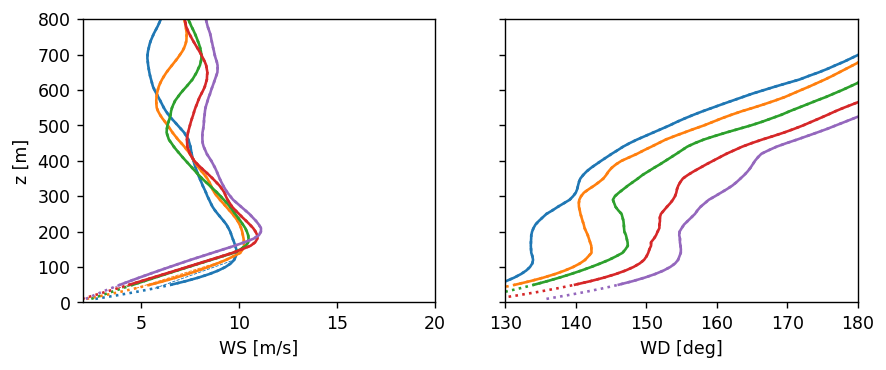

In [6]:
iplot = range(5) #range(9) #[0, 6, 12, 24, 48, 60, 72, 84, 96, 108, 120]
fig,ax = plt.subplots(1,2,figsize=(8,3), dpi=125, sharey=True)
for i in iplot:
    t = ldr_time[i]
    #line, = ax[0].plot(prof_WS[i,:], prof_heights, linestyle='--', lw=0.5)
    #ax[0].plot(ldr_WS[i,6:], ldr_heights[6:], color=line.get_color(), linestyle='-')
    line, = ax[0].plot(mergeWS[i,:], mergez, linestyle='--', lw=0.5)
    ax[0].plot(ldr_WS[i,:], ldr_heights, linestyle='-',color=line.get_color())
    ax[0].plot(fullWS[i,:], fullz, linestyle=':',color=line.get_color())
    
    ax[1].plot(ldr_WD[i,:], ldr_heights, linestyle='-',color=line.get_color())
    ax[1].plot(fullWD[i,:], fullz, linestyle=':',color=line.get_color())
    
ax[0].set_ylim([0, 800])
ax[1].set_xlim([130, 180])
ax[0].set_xlim([2, 20])
ax[0].set_ylabel('z [m]')
ax[0].set_xlabel('WS [m/s]')
ax[1].set_xlabel('WD [deg]')

Text(0.5, 0, 'WD [deg]')

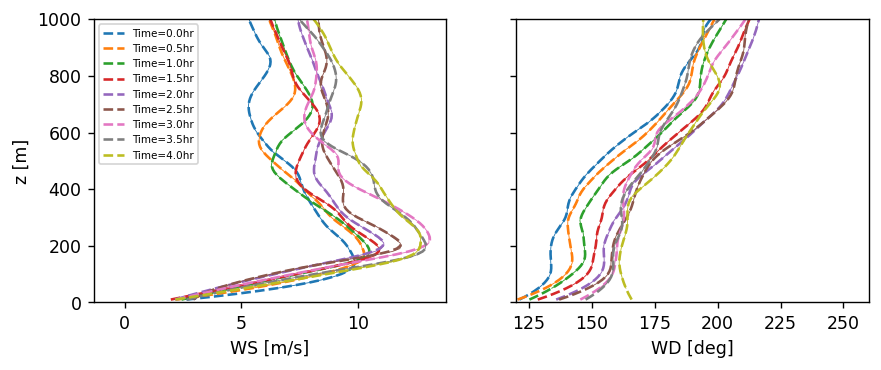

In [7]:
# Plot the original data
iplot = range(9)
fig,ax = plt.subplots(1,2,figsize=(8,3), dpi=125, sharey=True)
for i in iplot:
    t = ldr_time[i]
    WSfilt = savgol_filter(fullWS[i,:], 11, 3)
    WDfilt = savgol_filter(fullWD[i,:], 11, 3)
    line,  = ax[0].plot(ldr_WS[i,:], ldr_heights, lw=0.5)
    ax[0].plot(WSfilt, fullz, color=line.get_color(), linestyle='--', label='Time=%0.1fhr'%(t/3600))
    
    ax[1].plot(ldr_WD[i,:], ldr_heights, lw=0.5, color=line.get_color(), label='Time=%0.1fhr'%(t/3600))
    ax[1].plot(WDfilt, fullz, '--', color=line.get_color())
    
plt.ylim([0, 1000])
ax[0].legend(prop={'size':6})
ax[1].set_xlim([120, 260])
ax[0].set_ylabel('z [m]')
ax[0].set_xlabel('WS [m/s]')
ax[1].set_xlabel('WD [deg]')

In [8]:
# Convert from WS to WD
all_U = []
all_V = []

for i, t in enumerate(ldr_time):
    theta = (270.0 - fullWD[i,:])*np.pi/180.0
    WS    = fullWS[i,:]
    U     = WS*np.cos(theta)
    V     = WS*np.sin(theta)
    all_U.append(U)
    all_V.append(V)

all_U = np.array(all_U)
all_V = np.array(all_V)

In [9]:
def pottemp(T, P0overP, exponent):
    """
    Convert temperature to potential temperature
    """
    return T*np.power(P0overP, exponent)

def PoverP0(z, T0, g=9.80665, cp=1004.68506, M=0.02896968, R0=8.314462618):
    """
    See formula at https://en.wikipedia.org/wiki/Atmospheric_pressure
    """
    exponent = cp*M/R0
    return np.power(1.0 - g*z/(cp*T0), exponent)

def PoverP0L(z, T0, g=9.80665, L=0.00976, M=0.02896968, R0=8.314462618):
    """
    See formula at https://en.wikipedia.org/wiki/Atmospheric_pressure
    """
    exponent =g*M/(R0*L)
    return np.power(1.0 - L*z/(T0), exponent)

In [10]:
# Convert the temperature
all_T = []
for i in range(len(ldr_time)):
    Tvec = []
    interpfT = PchipInterpolator(b_heights, b_temp[i,:],extrapolate=True)
    for j in range(len(fullz)):
        Tvec.append(interpfT(fullz[j]))
    all_T.append(Tvec)
    
all_T = np.array(all_T) + 273.15

old_T = all_T + 0.0

# Set the temperatures to an exponential profile
matchTj  = 6
#Tinf     = 307.75
expConst = 0.02

for i in range(len(ldr_time)):
    t = ldr_time[i]
    Tground = all_T[i,0]
    
    PP0 = PoverP0(fullz, Tground)
    #PP0 = PoverP0L(fullz, Tground, L=0.007)
    theta = pottemp(all_T[i,:], 1.0/PP0, 0.4/1.4)

    # Smooth out the bottom few points
    interpfT = PchipInterpolator(fullz[matchTj:], theta[matchTj:],extrapolate=True)
    for j in range(matchTj):
        theta[j] = interpfT(fullz[j])
        
    ## Make the bottom few points constant
    #for j in range(3):
    #    theta[j] = interpfT(fullz[3])
        
    all_T[i,:] = theta

Text(0.5, 1.0, 'ASSIST temperature')

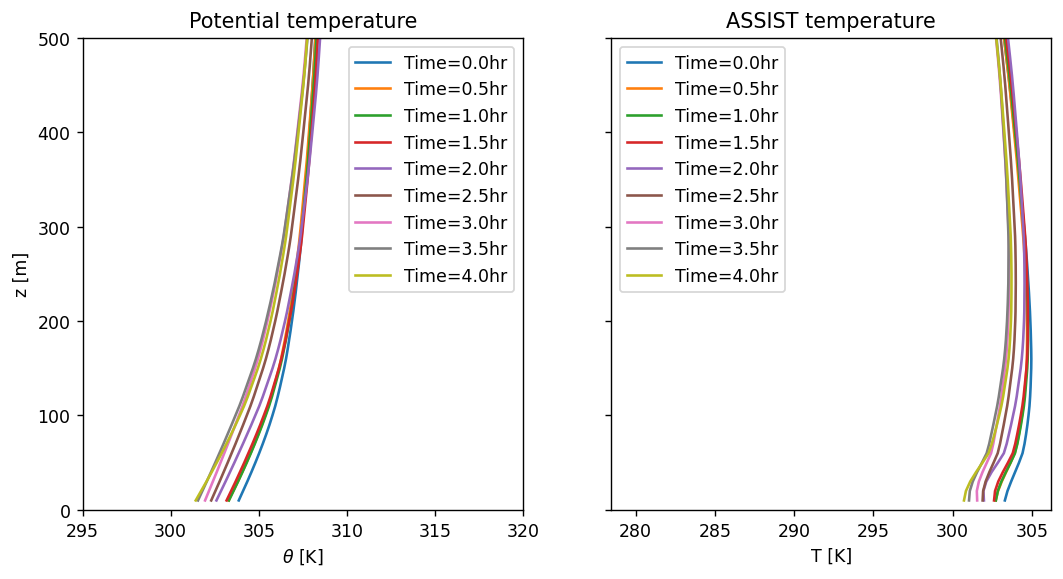

In [11]:
# Plot the original data
iplot = range(9)
fig,ax = plt.subplots(1,2,figsize=(10,5), dpi=125, sharey=True)
for i in iplot:
    t = ldr_time[i]
    ax[0].plot(all_T[i,:], fullz, label='Time=%0.1fhr'%(t/3600))
    ax[1].plot(old_T[i,:], fullz, label='Time=%0.1fhr'%(t/3600))
    
ax[0].set_ylim([0, 500])
ax[0].set_xlim([295, 320])
ax[0].set_ylabel('z [m]')
ax[0].set_xlabel('$\\theta$ [K]')
ax[0].legend()
ax[0].set_title('Potential temperature')
ax[1].set_xlabel('T [K]')
ax[1].legend()
ax[1].set_title('ASSIST temperature')

In [12]:
filterN = 11
polyN   = 3

blendw  = 100
maxzN   = 52 #149
#zblend  = fullz[maxzN] #zblend  = 300
all_Ublend = []
all_Vblend = []
all_Tblend = []

#print('zblend = %f'%zblend)

maxzTN = 15
#zTblend = fullz[maxzTN]
blendwT  = 100

zBlendTimes   = [0,  7200, 9000, 14401]
zBlendHeights = [550, 530, 300,  300]

zInvTimes   = [0,  7200, 9000, 14401]
zInvHeights = [450, 450, 325,  275]

#zInv     = 550
TatBlend = 311.5

all_heights = fullz

## Temperature profile
#lapserate = 8.0
#grounddT  = 2.0
#Tsurf = 278
#Tlow  = 280
Thigh = TatBlend+10.0
#Tprof = Tsurf + (Tlow-Tsurf)/(zblend)*all_heights

# Filter and blend to constant
for i, t in enumerate(ldr_time):
    #print(i)
    zblend = np.interp(t, zBlendTimes, zBlendHeights)
    zInv = np.interp(t, zInvTimes, zInvHeights)
    
    Ufilt = savgol_filter(all_U[i,:], filterN, polyN)
    Vfilt = savgol_filter(all_V[i,:], filterN, polyN)
    Tfilt = savgol_filter(all_T[i,:], filterN, polyN)
    
    Uzblend = np.interp(zblend, fullz, Ufilt)
    Vzblend = np.interp(zblend, fullz, Vfilt)
    Tzblend = np.interp(zblend, fullz, Tfilt)#all_T[i,:])
        
    # Merge the profiles
    blendU = blendprofiles(all_heights, all_heights[:maxzN], Ufilt[:maxzN],  Uzblend, zblend, blendw)
    blendV = blendprofiles(all_heights, all_heights[:maxzN], Vfilt[:maxzN],  Vzblend, zblend, blendw)
    #blendT = blendprofiles(all_heights, all_heights[:maxzTN], all_T[i,:maxzTN], Tzblend, zTblend, blendwT)
    blendT = blendprofiles(all_heights, all_heights,         all_T[i,:],         Thigh, zInv, blendwT)
    
    # Add the z=0 point
    U0 = PchipInterpolator(all_heights, blendU,extrapolate=True)(0.0)
    V0 = PchipInterpolator(all_heights, blendV, extrapolate=True)(0.0)
    T0 = PchipInterpolator(all_heights, blendT, extrapolate=True)(0.0)
    
    all_Ublend.append(np.concatenate(([U0], blendU)))
    all_Vblend.append(np.concatenate(([V0], blendV)))
    all_Tblend.append(np.concatenate(([T0], blendT)))
    #all_Tblend.append(blendT)
    
all_Ublend = np.array(all_Ublend)
all_Vblend = np.array(all_Vblend)
all_Tblend = np.array(all_Tblend)    
all_heights = np.insert(fullz, 0, 0.0)


Text(0.5, 0, '$\\Theta$ [K]')

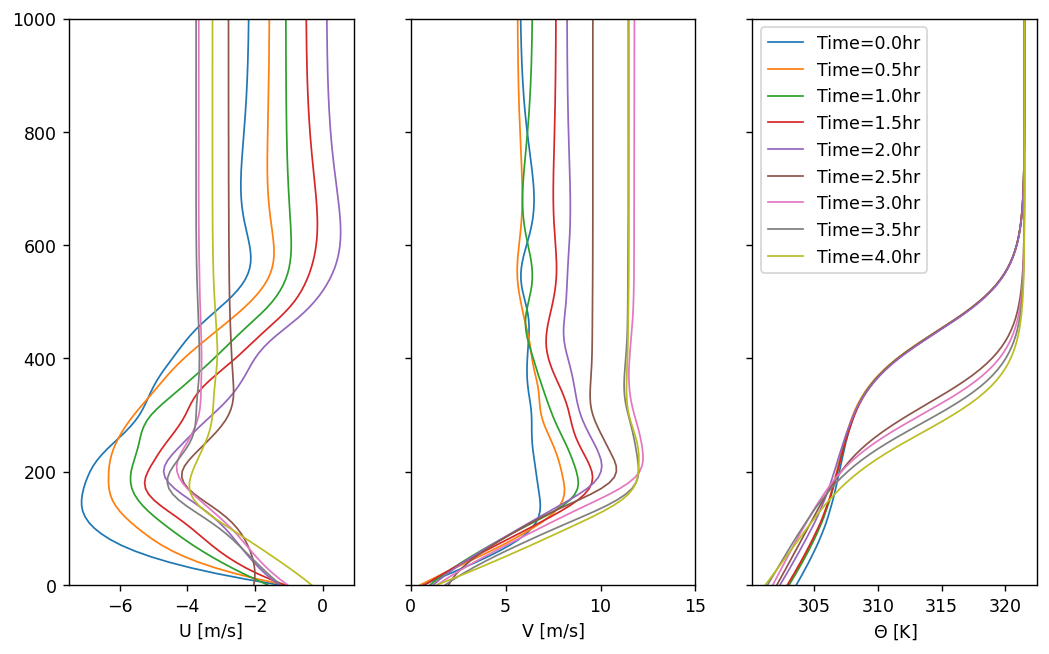

In [13]:
# Plot the original data
iplot = range(9)
fig,ax = plt.subplots(1,3,figsize=(10,6), dpi=125, sharey=True)
for i in iplot:
    t = ldr_time[i]
    line,  = ax[0].plot(all_Ublend[i,:], all_heights, lw=1)
    
    ax[1].plot(all_Vblend[i,:], all_heights, lw=1, color=line.get_color(), label='Time=%0.1fhr'%(t/3600))
    ax[2].plot(all_Tblend[i,:], all_heights, lw=1, color=line.get_color(), label='Time=%0.1fhr'%(t/3600))
    
ax[0].set_ylim([0, 1000])
#ax[0].set_xlim([-5, 10])
ax[1].set_xlim([0, 15])
ax[2].legend()

ax[0].set_xlabel('U [m/s]')
ax[1].set_xlabel('V [m/s]')
ax[2].set_xlabel('$\Theta$ [K]')

In [14]:
# Set the temperature flux
fluxdat = []
for i, t in enumerate(ldr_time):
    #tflux = PchipInterpolator(b_tflux[:,0], b_tflux[:,1],extrapolate=True)(t)
    tflux = 0.0
    fluxdat.append(tflux)
    
fluxdat= 0*np.array(fluxdat)

(-10.0, 2.0)

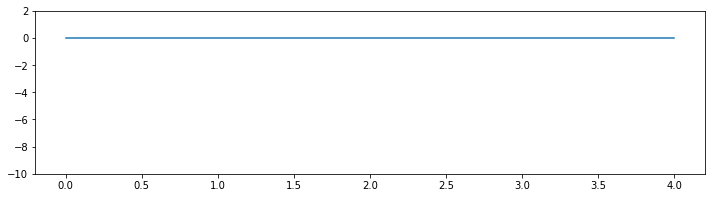

In [15]:
plt.figure(figsize=(12,3))
plt.plot(ldr_time/3600, fluxdat)
plt.ylim([-10,2])

In [16]:
#raise ValueError('Stop')

## Save the data

### Conditions
https://www.wunderground.com/history/daily/us/ok/enid/KOKC/date/2023-8-24 

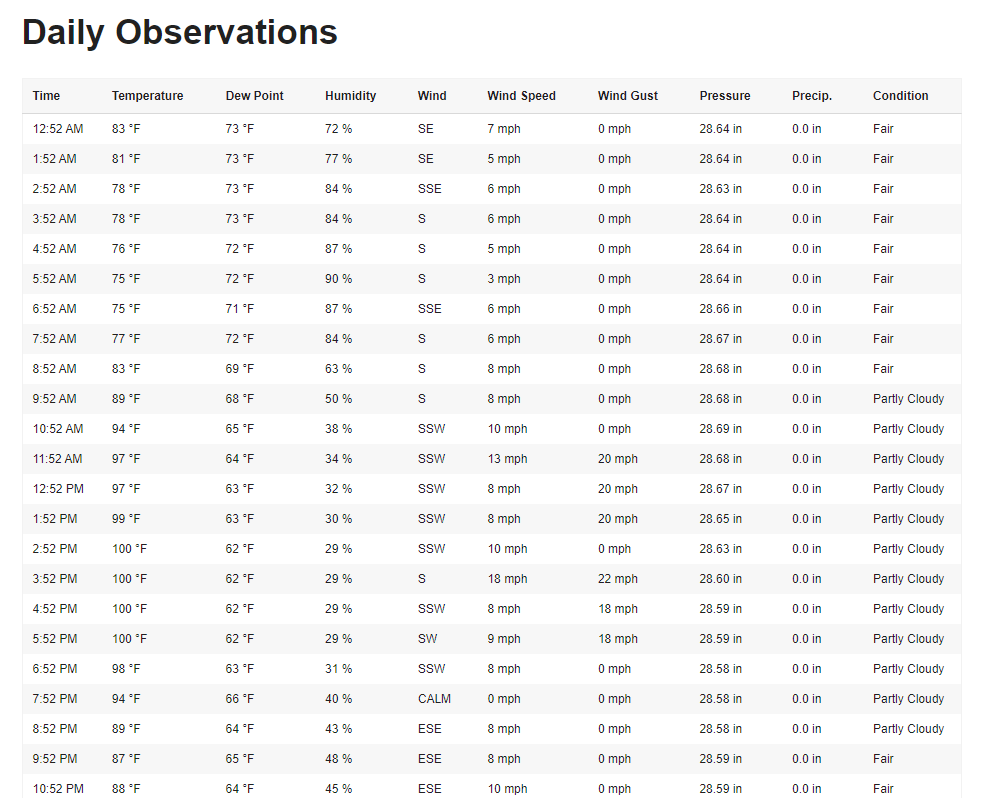

Pressure: 28.64 in Hg = 96986.171 Pa

Temperature: 302 K

Humidity: 87%

Air density: 1.103707 kg/m^3

https://www.omnicalculator.com/physics/air-density


In [17]:
suffix      = 'BigPrecursor'
rundir      = 'MMC_BM3_'+suffix
ICfilename  = 'init.nc'
MMCfilename = 'MMC.nc'
amrfilename = 'abl_HPP_MMC.inp'
rho         = 1.103707

# Go to the run directory
if not os.path.exists(rundir):
    os.makedirs(rundir)

In [18]:
# Save the data to text files
np.savetxt(rundir+'/MMC_Ublend%s.dat'%suffix, all_Ublend)
np.savetxt(rundir+'/MMC_Vblend%s.dat'%suffix, all_Vblend)
np.savetxt(rundir+'/MMC_Tblend%s.dat'%suffix, all_Tblend)
np.savetxt(rundir+'/MMC_all_heights.dat',     all_heights)
np.savetxt(rundir+'/MMC_time_sec.dat',        ldr_time)

## Set up precursor domain

In [19]:
turbines=[]
addKingPlains     = True
addArmadilloFlats = False

# All turbines must fit within these utm limits 
turb_inside_box = [[627500, 650000],  # UTM Easting
                   [4.016E6, 4.035E6],  # UTM Northing  
                  ]

In [20]:
# Load the data from the database of all turbines
df = pd.read_csv('../KPAF_info_new.csv',low_memory=False)

In [21]:
# Fix the FarmID of teh turbines
for index, row in df.iterrows():
    if row['turbine_qc_id'].startswith('WIT_USKPL_SS001'):
        df.loc[index, 'Unnamed: 0']='King Plains'
    if row['turbine_qc_id'].startswith('WAF1'):
        df.loc[index, 'Unnamed: 0']='Armadillo Flats'
    
#for index, row in df.iterrows(): print(row['Unnamed: 0'] + ' '+ row['turbine_qc_id'])

In [22]:
# Add King Plains turbines
KPturbs1=df[df['Unnamed: 0']=="King Plains"]
KPcount = 0

if addKingPlains:
    ge2p8='GE2.8-127'
    turblist = []
    # Turbines from Noble County
    for index, row in KPturbs1.iterrows():
        utmxy   = utm.from_latlon(row['turbine_latitude'], row['turbine_longitude'])
        if ((utmxy[0] < turb_inside_box[0][0]) or (utmxy[0] > turb_inside_box[0][1]) or 
            (utmxy[1] < turb_inside_box[1][0]) or (utmxy[1] > turb_inside_box[1][1])):
            continue
        datarow = {'faa_asn':row['turbine_qc_id'], 
                   'lat':row['turbine_latitude'], 'long':row['turbine_longitude'], 'utm':(utmxy[0], utmxy[1]), 
                   't_model':ge2p8}
        turbines.append(datarow)
        if datarow['t_model'] not in turblist: turblist.append(datarow['t_model'])
        KPcount += 1
        
    print("King Plains: %i turbines"%(KPcount))
    print('Turbine types: '+repr(turblist))
    

King Plains: 85 turbines
Turbine types: ['GE2.8-127']


In [23]:
# Add Armadillo Flats turbines
AFturbs=df[df['Unnamed: 0']=="Armadillo Flats"]

if addArmadilloFlats:
    turbmodeldict = {1.72:'GE1.7-103',
                     1.79:'GE1.79-100',
                     2.3:'GE2.3-116',
                    }
    
    turblist = []
    # Turbines from Noble County
    for index, row in AFturbs.iterrows():
        utmxy   = utm.from_latlon(row['turbine_latitude'], row['turbine_longitude'])
        if ((utmxy[0] < turb_inside_box[0][0]) or (utmxy[0] > turb_inside_box[0][1]) or 
            (utmxy[1] < turb_inside_box[1][0]) or (utmxy[1] > turb_inside_box[1][1])):
            continue
        datarow = {'faa_asn':row['turbine_qc_id'], 
                   'lat':row['turbine_latitude'], 'long':row['turbine_longitude'], 'utm':(utmxy[0], utmxy[1]), 
                   't_model':turbmodeldict[row['turbine_nameplate']]}
        turbines.append(datarow)
        if datarow['t_model'] not in turblist: turblist.append(datarow['t_model'])
        
    print("Armadillo Flats: %i turbines"%(len(AFturbs)))
    print('Turbine types: '+repr(turblist))

In [24]:
summitcsv = rundir+'/turbines.csv'

verbose=False

# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
header="""# name, x, y, type, yaw, hubheight, options"""
with open(summitcsv, 'w') as f:
    f.write(header+'\n')
    if verbose: print(header)
    for x in turbines: 
        #line='%s, %f, %f, %s, , ,'%(x['faa_asn'], x['lat'], x['long'], 'Summit_'+x['t_model'])
        line='%s, %f, %f, %s, , ,'%(x['faa_asn'], x['utm'][0], x['utm'][1], 'Summit_'+x['t_model'])
        f.write(line+'\n')
        if verbose: print(line)

## AWAKEN Wind farm layout for Summit

**Note**: to make sure that the correct turbines are in place for setting up this layout file, make sure something like this file is in place:

In [25]:
#with open("../../../turbines/summitlayoutturbs.yaml")as f: print(f.read())

## Set up the ABL parameters and conditions

In [26]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [27]:
WS     = 10.05         # Wind speed, m/s
WDir   = 180           # Wind direction, degrees
farm_domainsize = [2.4*10000.0, 1.76*10000.0, 800]
farm_center     = [637500, 4.030E6]   # In utm
#print(utm.from_latlon(36.587395, -97.756294))
#farm_center          = utm.to_latlon(640000, 4030000, 14, 'S')
print("Farm center = "+repr(farm_center)) # in lat/long
farm_background_mesh = 10 

Farm center = [637500, 4030000.0]


In [28]:
# Set the wind speed and direction
case.setAMRWindInput('useWSDir', True)                           # Allows you to specify wind speed + wind direction 
case.setAMRWindInput('ABL_windspeed', WS, forcechange=True)     # Wind speed of 9 m/s
case.setAMRWindInput('ABL_winddir',   WDir, forcechange=True)     # Wind direction of 175 degrees
case.ABL_calculateWindVector()

In [29]:
# Set some tolerances (leave this alone)
tols = """
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol                       = 1e-12               
mac_proj.mg_rtol                         = 1e-06               
mac_proj.mg_atol                         = 1e-12               
diffusion.mg_rtol                        = 1e-06               
diffusion.mg_atol                        = 1e-12               
temperature_diffusion.mg_rtol            = 1e-10               
temperature_diffusion.mg_atol            = 1e-13               
"""
case.loadAMRWindInput(tols, string=True);

In [30]:
case.loadTurbineCSVFile(summitcsv)

In [31]:
case.setAMRWindInput('turbines_coordsys', 'utm')

# Set up the domain 
case.setAMRWindInput('turbines_domainsize',         farm_domainsize)
case.setAMRWindInput('turbines_backgroundmeshsize', farm_background_mesh)
case.setAMRWindInput('turbines_autocalccenter',     False)
case.setAMRWindInput('turbines_farmcenter',         [farm_center[0], farm_center[1]])
case.setAMRWindInput('turbines_deleteprev', True)

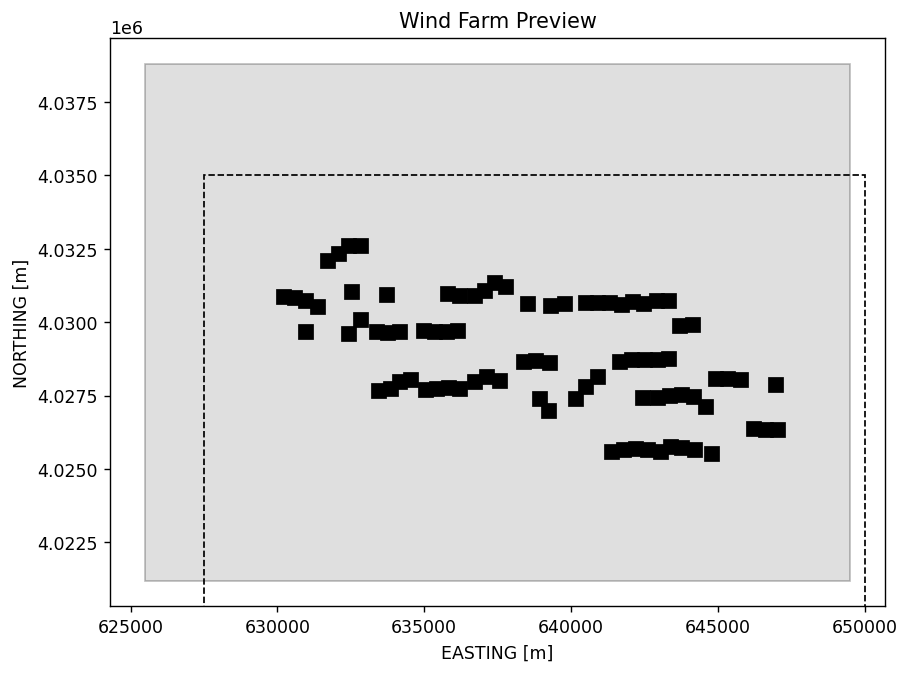

In [32]:
# Preview the turbine layout
fig, ax = plt.subplots(figsize=(8,8), facecolor='w', dpi=125)
case.setAMRWindInput('turbines_plotnames', False)
#case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.turbines_previewAllTurbines(ax=ax)

rect = patches.Rectangle((turb_inside_box[0][0], turb_inside_box[1][0]), 
                         turb_inside_box[0][1]-turb_inside_box[0][0], 
                         turb_inside_box[1][1]-turb_inside_box[1][0], linewidth=1, edgecolor='k', linestyle='--', facecolor='none')
ax.add_patch(rect)

In [33]:
case.getAMRWindInput('turbines_farmcenter')

[637500.0, 4030000.0]

In [34]:
case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(len(case.listboxpopupwindict['listboxactuator'].getitemlist()))

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()
85


## Add refinements

In [35]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
#0,     13800,    15000,      18500,  100,  250,      center:farm units:meter
# KP
#0,     4250,    4200,      9500,  100,  75, center:specified units:meter centerx:638500 centery:4029000 centerz:100
0,     4250,    3500,      4750,  100,  75, center:specified units:meter centerx:643000 centery:4029000 centerz:100
0,     2700,    4200,      4750,  100,  75, center:specified units:meter centerx:634000 centery:4029000 centerz:100

# AF
#0,     4000,    6000,      5000,  100,  350, center:specified units:meter centerx:632000 centery:4018000 centerz:100   
#0,     4000,    3000,      7000,  100,  350, center:specified units:meter centerx:618000 centery:4035000 centerz:100

# Turbine refinement
#1,     2.0,    2.0,     2.0,    0.525, 0.525, orientation:nacdir
1,     0.6,    0.6,     0.6,    0.525, 0.525, orientation:nacdir
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

In [36]:
case.refine_createAllZones()

(624300.0, 650700.0, 4020320.0, 4039680.0)

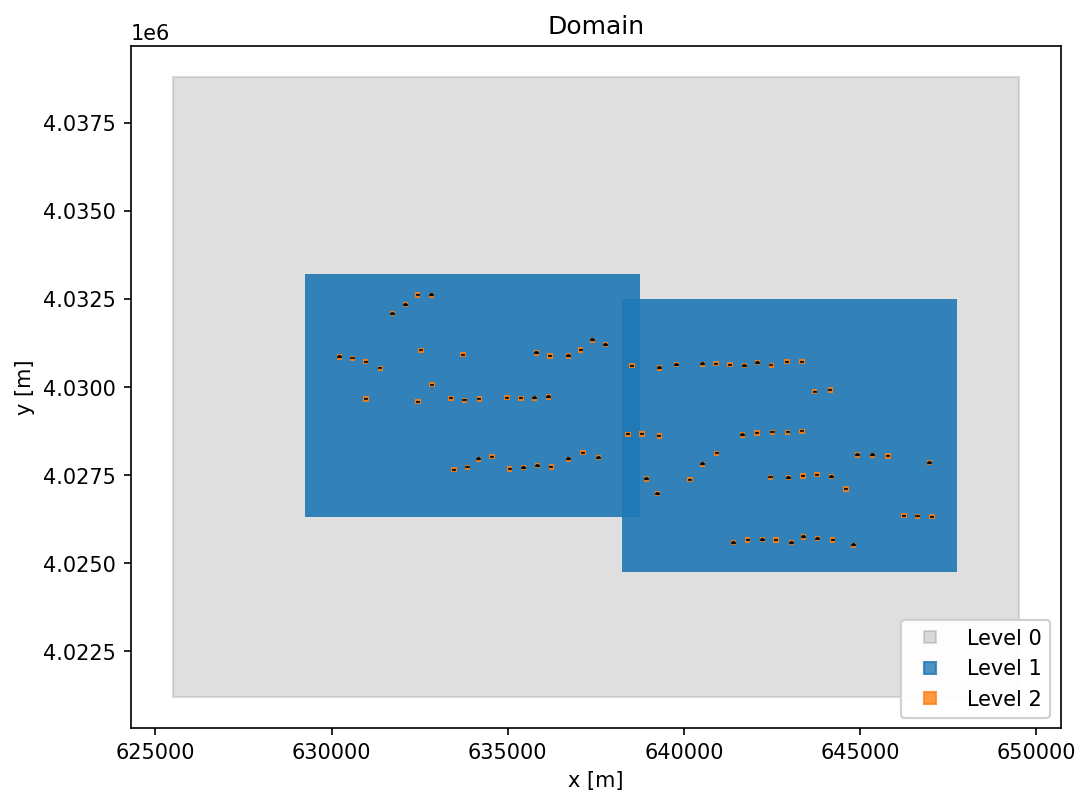

In [37]:
# Plot the domain (total domain)
fig, ax = plt.subplots(figsize=(8,8), facecolor='w', dpi=150)
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = False
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.plotDomain(ax=ax)
ax.axis('scaled')

(624300.0, 650700.0, -229.10497084952578, 849.0049986118822)

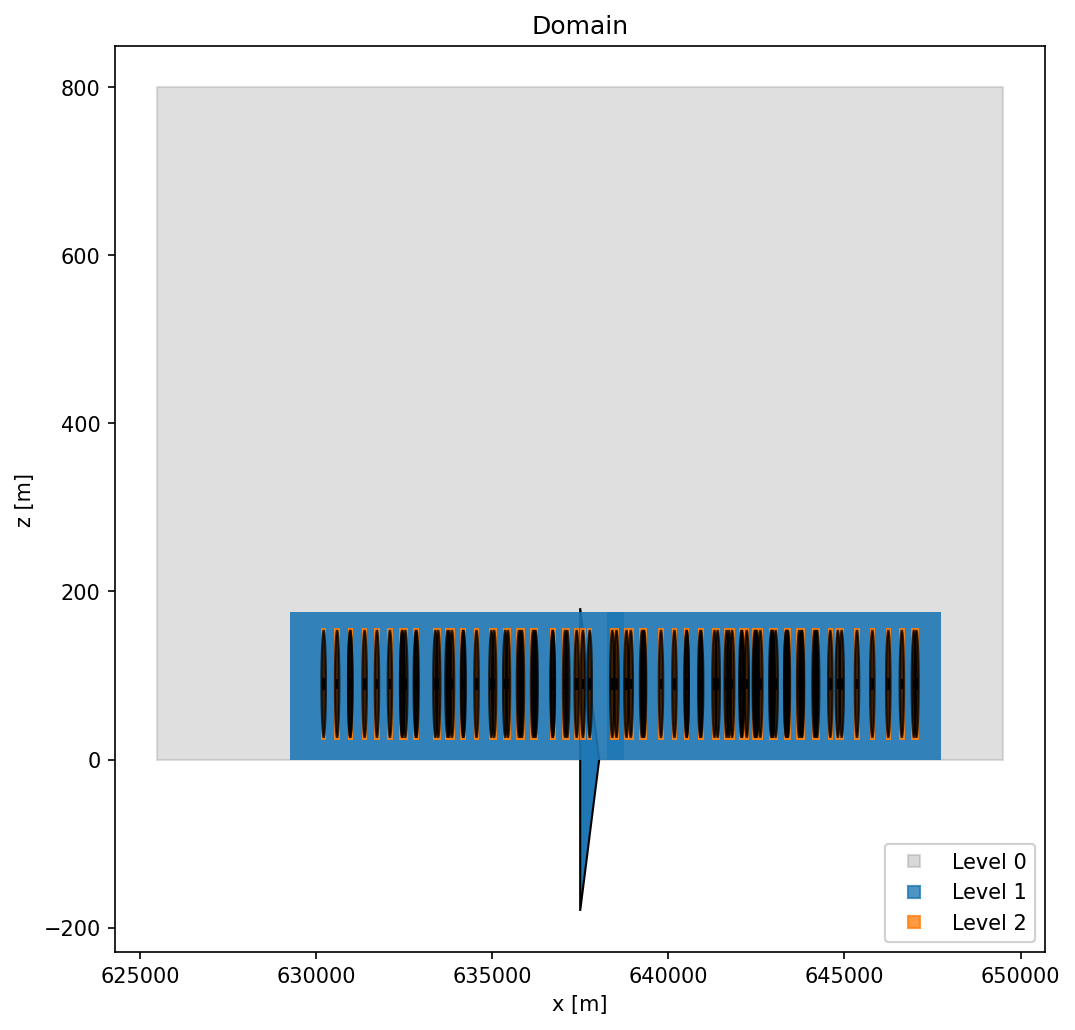

In [38]:
# Plot the domain (total domain)
fig, ax = plt.subplots(figsize=(8,8), facecolor='w', dpi=150)
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = True
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XZ'
case.plotDomain(ax=ax)
ax.axis('auto')

In [39]:
case.listboxpopupwindict['listboxactuator'].deleteall()
print(case.listboxpopupwindict['listboxactuator'].getitemlist())

case.listboxpopupwindict['listboxtagging'].deleteall()
print(case.listboxpopupwindict['listboxtagging'].getitemlist())

case.setAMRWindInput('amr.max_level', 0)

[]
[]


In [40]:
# Estimate mesh size
case.estimateMeshSize(verbose=False)

ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0    337920000             10.0 x 10.0 x 10.0
  TOTAL:    337920000


In [41]:
#raise ValueError('Stop here')

## Set up AMR-Wind case

In [42]:
# Start the case
#case = amrwind.MyApp.init_nogui()

In [43]:
case.setAMRWindInput('time_control', ['const dt'])
case.setAMRWindInput('time.fixed_dt',  0.50)

In [44]:
# Set the time constants
case.setAMRWindInput('time.stop_time', 4*3600.0)
case.setAMRWindInput('time.max_step',  -1)

case.setAMRWindInput('time.checkpoint_interval',  1800)

In [45]:
# Set some basic parameters
case.setAMRWindInput('incflo.physics',      ['ABL'])  # Must have ABL physics to do ABL calculations
case.setAMRWindInput('incflo.verbose',      3)        # This is optional, verbose=3 means more info in the output logs
case.setAMRWindInput('io.check_file',       'chk')    # What to name the checkpoint files

case.setAMRWindInput('incflo.use_godunov',  True)       # Always use a godunov scheme
case.setAMRWindInput('incflo.godunov_type', 'weno_z')   # Use 'weno_z' 

case.setAMRWindInput('turbulence.model',    ['OneEqKsgsM84'])    # One equation k-sgs subgrid scale model
case.setAMRWindInput('TKE.source_terms',    ['KsgsM84Src'])      # The corresponding source term

case.setAMRWindInput('transport.viscosity', 1.771e-05)           # dynamic viscosity, based on median air temperature of 284.47 K from 2 m above E06, units Pa-s
case.setAMRWindInput('incflo.density',      rho)                 # density, based on 1017.13*100./(284.47)/287.058 where 1017.13 is median air pressure from 2 m above E06 
                                                                 #   and 284.47 is median air temperature from 2 m above E06, units kg/
case.setAMRWindInput('incflo.velocity',      [0, 0, 0])

In [46]:
# To set up the sampling output
case.setAMRWindInput('time.plot_interval',        -1) 

In [47]:
# Set some tolerances (leave this alone)
tols = """
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol                       = 1e-12               
mac_proj.mg_rtol                         = 1e-06               
mac_proj.mg_atol                         = 1e-12               
diffusion.mg_rtol                        = 1e-06               
diffusion.mg_atol                        = 1e-12               
temperature_diffusion.mg_rtol            = 1e-10               
temperature_diffusion.mg_atol            = 1e-13               
"""
case.loadAMRWindInput(tols, string=True);

case.setAMRWindInput('incflo.do_initial_proj', 0)
case.setAMRWindInput('incflo.initial_iterations', 0)

In [48]:
# This cell sets up boundary conditions
case.setAMRWindInput('is_periodicx', True)     # periodic in x
case.setAMRWindInput('is_periodicy', True)     # periodic in y
case.setAMRWindInput('is_periodicz', False)    # Enforce some boundary conditions in z

In [49]:
# Boundary conditions in z
case.setAMRWindInput('zlo.type',              'wall_model')          
case.setAMRWindInput('zlo.tke_type',          'zero_gradient')       
case.setAMRWindInput('zhi.type',              'slip_wall')           
case.setAMRWindInput('zhi.temperature_type',  'fixed_gradient')    

In [50]:
# Now set up ABL specific forces, parameters, etc.
case.setAMRWindInput('ICNS.source_terms',            ['BoussinesqBuoyancy','ABLMesoForcingMom','ABLMeanBoussinesq',])
case.setAMRWindInput('Temperature.source_terms',     ['ABLMesoForcingTemp',])

case.setAMRWindInput('ABL.stats_output_frequency',   1, forcechange=True)           # Output ABL stats every iteration            
case.setAMRWindInput('ABL.stats_output_format',   'netcdf', forcechange=True)       # Use netcdf output because that's how we postprocess

case.setAMRWindInput('ABLForcing.abl_forcing_height',   150)       # Hub height wind speed you want specify 
case.setAMRWindInput('ABL.kappa',                       0.4)      # Kolmogorov constant

case.setAMRWindInput('ABL.normal_direction',      2)              # vertical is in z
case.setAMRWindInput('ABL.surface_roughness_z0',  0.0001)           # Surface roughess, SOMETHING WE WILL PROBABLY WANT TO ITERATE ON
case.setAMRWindInput('ABL.reference_temperature', 300.0)        # Correspond to what was measured at ARM

case.setAMRWindInput('ABL.perturb_temperature',    True, forcechange=True)
case.setAMRWindInput('ABL.perturb_velocity',       True, forcechange=True)

# Monin-Obukhov parameters (No need to change)
case.setAMRWindInput('ABL.mo_beta_m',             16.0)
case.setAMRWindInput('ABL.mo_gamma_m',            5.0)
case.setAMRWindInput('ABL.mo_gamma_h',            5.0)
case.setAMRWindInput('ABL.random_gauss_mean',     0.0)
case.setAMRWindInput('ABL.random_gauss_var',      1.0)

case.setAMRWindInput('BoussinesqBuoyancy.reference_temperature', 300.0)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


### Set up sampling planes

In [51]:
# Delete all old sampling planes from precursor
case.listboxpopupwindict['listboxsampling'].deleteall()
case.listboxpopupwindict['listboxpostprosetup'].deleteall()

In [52]:
replacedict={
    'farmcenterx':case.getAMRWindInput('turbines_farmcenter')[0],
    'farmcentery':case.getAMRWindInput('turbines_farmcenter')[1],
    'farmcenterz':90.0,
}


samplingcsv="""
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
#cl1, centerline, 1,  0, none, none,  none,  11, 11, none
#rp1, rotorplane, 2,  0, none, none,  none,  11, 11, none
#sw1, streamwise, 2,  1, 1, 0.5,  0.5,  11, 11, usedx:0.25 noffsets:1
#sw1, streamwise,  2,  1, 1, 0.5,  0.5,  11, 11, usedx:10 wholedomain:1 units:meter center:specified centerx:0 centery:0 centerz:90 orientation:y outputvars:velocity;tke;temperature outputfreq:10 outputto:sw_
#hh,  hubheight,   0,  0,1000, 0,  none,  11, 11, usedx:10 wholedomain:1 units:meter center:specified centerx:0 centery:0 centerz:90 outputvars:velocity;tke;temperature outputfreq:10 outputto:hubheight_

sw1, streamwise,  2,  1, 1, 0.5,  0.5,  11, 11, usedx:20 wholedomain:1 units:meter center:specified centerx:{farmcenterx} centery:{farmcentery} centerz:{farmcenterz} orientation:x outputvars:velocity;tke;temperature outputfreq:20 outputto:sw_
hh,  hubheight,   0,  0,1000, 0,  none,  11, 11, usedx:20 wholedomain:1 units:meter center:specified centerx:{farmcenterx} centery:{farmcentery} centerz:{farmcenterz} outputvars:velocity;tke;temperature outputfreq:20 outputto:hubheight_
""".format(**replacedict)

In [53]:
case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', True)
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['Farm_sw1', 'Farm_hh']


## MMC parameters

In [54]:
tstart      = 0.0

In [55]:
# Set the MMC inputs
zstr, Tstr = writeMMC.makeIC_fromMMC(case.getAMRWindInput('geometry.prob_lo'), 
                                     case.getAMRWindInput('geometry.prob_hi'), 
                                     case.getAMRWindInput('amr.n_cell'), 
                                     all_Ublend, all_Vblend, all_Tblend,
                                     ldr_time, all_heights, rundir+'/'+ICfilename, tstart, verbose=True)
writeMMC.makeMMCforcing(case.getAMRWindInput('geometry.prob_lo'), 
                        case.getAMRWindInput('geometry.prob_hi'), 
                        case.getAMRWindInput('amr.n_cell'), 
                        all_Ublend, all_Vblend, all_Tblend, fluxdat,
                        ldr_time, all_heights, rundir+'/'+MMCfilename)

# These inputs set up the initial temperature profile (Same as Nalu-Wind temperature profile)
case.setAMRWindInput('ABL.temperature_heights', zstr)
case.setAMRWindInput('ABL.temperature_values',  Tstr)

# MMC files
case.setAMRWindInput('ABL.initial_condition_input_file', ICfilename) # this is only for u,v
case.setAMRWindInput('ABL.mesoscale_forcing', MMCfilename)

case.setAMRWindInput('ABLMesoForcingMom.forcing_scheme', "direct")
case.setAMRWindInput('ABLMesoForcingTemp.forcing_scheme', "direct")

#case.setAMRWindInput('ABLMesoForcingMom.forcing_transition',  "directToConstant")
#case.setAMRWindInput('ABLMesoForcingTemp.forcing_transition', "directToConstant")
#case.setAMRWindInput('ABLMesoForcingMom.constant_transition_height',  450.0)
#case.setAMRWindInput('ABLMesoForcingTemp.constant_transition_height', 450.0)
#case.setAMRWindInput('ABLMesoForcingMom.transition_thickness',  100.0)
#case.setAMRWindInput('ABLMesoForcingTemp.transition_thickness', 100.0)

[============================================================] 100.0% 


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[============================================================] 100.0% 


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



NETCDF4
Wrote heights and times
Wrote momentum profiles
Wrote temperature profiles
Wrote tflux profiles
Done


In [56]:
# UNCOMMENT THIS LATER
# Add boundary plane inputs
case.setAMRWindInput('ABL_useboundaryplane',        True)
case.setAMRWindInput('ABL.bndry_file',              'bndry_file')
case.setAMRWindInput('ABL.bndry_io_mode',           '0')
case.setAMRWindInput('ABL.bndry_planes',            ['xlo','ylo', 'xhi', 'yhi'])
case.setAMRWindInput('ABL.bndry_output_start_time', 7000.0)
case.setAMRWindInput('ABL.bndry_var_names',         'velocity temperature tke')

In [57]:
# Estimate mesh size
case.estimateMeshSize(verbose=False)

ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0    337920000             10.0 x 10.0 x 10.0
  TOTAL:    337920000


In [58]:
# Write the input file
print(case.writeAMRWindInput(rundir+'/'+amrfilename))

# --- Simulation time control parameters ---
time.stop_time                           = 14400.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.5                 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 1800                
incflo.physics                           = ABL                 # List of physics models to include in simulation.
incflo.verbose                           = 3                   
io.check_file                            = chk                 
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84        
TKE.source_terms                         = KsgsM84Src          
nodal_proj.mg_rtol                       = 1e-06               
nodal_proj.mg_atol             